In [2]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0,

In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


# Data Prepration Pipeline

In [4]:
#augmentation for data generators
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',)

In [5]:
#set training/testing images/masks folder path
train_img_path = "/content/drive/MyDrive/Image_Segmentation/Data/train_images/" 
train_mask_path = "/content/drive/MyDrive/Image_Segmentation/Data/train_masks/"

val_img_path = "/content/drive/MyDrive/Image_Segmentation/Data/val_images/"
val_mask_path = "/content/drive/MyDrive/Image_Segmentation/Data/val_masks/"

In [6]:
#Run this if images are more in training folder and masks are less (Not all labels, remove un labeled images)

if len(os.listdir('/content/drive/MyDrive/Image_Segmentation/Data/train_images/train')) != len(os.listdir('/content/drive/MyDrive/Image_Segmentation/Data/train_masks/train')):
  images = os.listdir('/content/drive/MyDrive/Image_Segmentation/Data/train_images/train')
  masks = os.listdir('/content/drive/MyDrive/Image_Segmentation/Data/train_masks/train')
  not_present=[]
  for each in images:
    try:
      masks.index(each)
    except:
      not_present.append(each)

  for each in not_present:
    os.remove('/content/drive/MyDrive/Image_Segmentation/Data/train_images/train/'+each)

In [13]:
#images
image_data_generator = ImageDataGenerator(**img_data_gen_args, rescale=1.0/255.0)
image_generator = image_data_generator.flow_from_directory(train_img_path, batch_size=2, 
                                                           seed=54, target_size=(128,128),
                                                           class_mode=None, color_mode='rgb')
image_data_generator = ImageDataGenerator(rescale=1.0/255.0)
valid_img_generator = image_data_generator.flow_from_directory(val_img_path, batch_size=2, 
                                                               seed=54,target_size=(128,128),
                                                               class_mode=None, color_mode='rgb')
#masks
mask_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(train_mask_path, batch_size=2,
                                                         seed=54, target_size=(128,128),
                                                         class_mode=None)
mask_data_generator = ImageDataGenerator()
valid_mask_generator = mask_data_generator.flow_from_directory(val_mask_path, batch_size=2, 
                                                               seed=54, target_size=(128,128),
                                                               class_mode=None)

Found 339 images belonging to 2 classes.
Found 101 images belonging to 2 classes.
Found 339 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


In [14]:
#Create data generators
import numpy as np
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
      mask=mask[:,:,:,0]
      # mask = mask.astype('uint8')
      mask=np.expand_dims(mask, axis=3)
      yield (img, mask)

In [15]:
my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

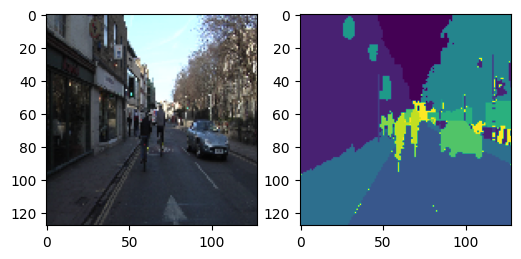

In [16]:
import matplotlib.pyplot as plt
#for combine
# x, y = my_generator.__next__()
x, y = validation_datagen.__next__()
plt.figure(figsize=(6,6))
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,:])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], )
    plt.show()

In [17]:
np.unique(mask)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

In [18]:
print(mask.shape)

(128, 128, 1)


In [19]:
#steps per epoch
num_imges=len(os.listdir(train_img_path+"train/"))
num_vals=len(os.listdir(val_img_path+"/val/"))

steps_per_epoch=num_imges//2
validation_steps=num_vals//2
steps_per_epoch, validation_steps

(169, 50)

# With VGG16 Base Line

In [21]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

In [ ]:
model_1 = sm.Unet('vgg16', classes=12, input_shape=(128,128,3)) 

In [ ]:
model_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [23]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[jaccard_distance])

In [ ]:
#Fit the model
history = model_1.fit(my_generator, validation_data=validation_datagen, 
                      steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=15)

Epoch 1/15
169/169 [==============================] - 34s 122ms/step - loss: 1.3611 - jaccard_distance: 40.6449 - val_loss: 1.4117 - val_jaccard_distance: 44.7484
Epoch 2/15
169/169 [==============================] - 19s 111ms/step - loss: 1.2302 - jaccard_distance: 44.0946 - val_loss: 1.3035 - val_jaccard_distance: 44.3124
Epoch 3/15
169/169 [==============================] - 20s 119ms/step - loss: 1.1565 - jaccard_distance: 44.9692 - val_loss: 1.9471 - val_jaccard_distance: 52.1488
Epoch 4/15
169/169 [==============================] - 19s 111ms/step - loss: 1.1042 - jaccard_distance: 45.9697 - val_loss: 1.2326 - val_jaccard_distance: 44.7835
Epoch 5/15
169/169 [==============================] - 20s 119ms/step - loss: 1.0544 - jaccard_distance: 47.0618 - val_loss: 1.0847 - val_jaccard_distance: 43.2134
Epoch 6/15
169/169 [==============================] - 19s 113ms/step - loss: 1.0260 - jaccard_distance: 47.1047 - val_loss: 1.2373 - val_jaccard_distance: 40.2955
Epoch 7/15
169/169 [==

In [ ]:
#specify save path
model_1.save('')

In [24]:
#load model from saved path
from tensorflow.keras.models import load_model
model_1=load_model('/content/drive/MyDrive/Image_Segmentation/model_vgg16.hdf5',  compile=False)
model_1.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[jaccard_distance])

(128, 128, 1)
(1, 128, 128, 3)
1/1 [==============================] - 3s 3s/step
(128, 128, 12)


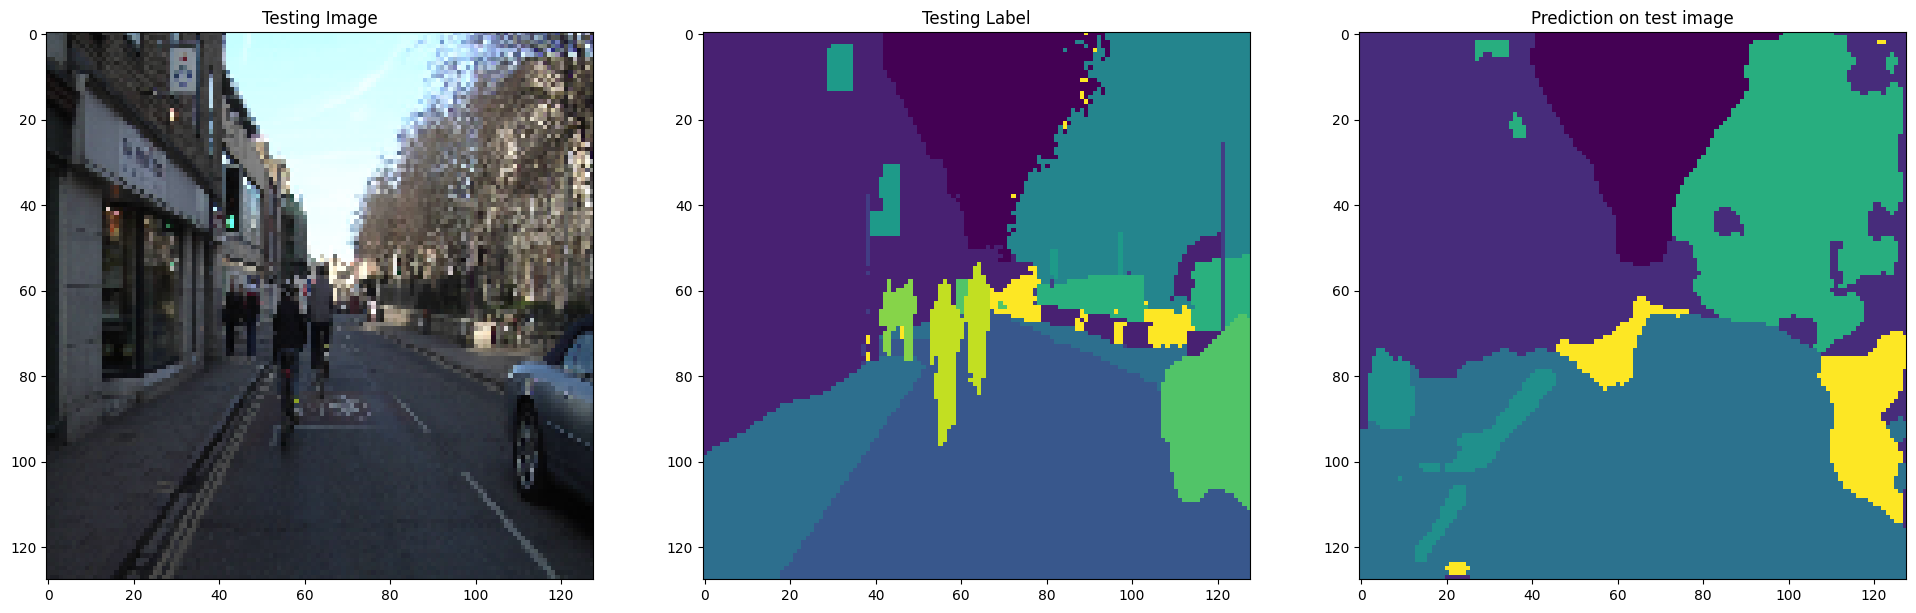

In [25]:
#making predictions
threshold = 0.5
#test_img_number = random.randint(0, num_vals-1)
x, y=validation_datagen.__next__()
for i in range(0,1):
  test_img=x[i]
  ground_truth=y[i]
  print(ground_truth.shape)

# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model_1.predict(test_img_input)[0,:,:,:])
print(prediction.shape)

plt.figure(figsize=(24, 24))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,:], )
plt.subplot(233)
prediction = np.argmax(prediction, axis=-1)
plt.title('Prediction on test image')
plt.imshow(prediction, )

plt.show()

# With Resnet50 Base Line

In [ ]:
model_2 = sm.Unet('resnet50', classes=12, input_shape=(128,128,3)) 

In [ ]:
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']   

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[jaccard_distance])

In [ ]:
#Fit the model
history = model_2.fit(my_generator, validation_data=validation_datagen, 
                      steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=15)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 59s 126ms/step - loss: 1.4262 - jaccard_distance: 36.9286 - val_loss: 10.3831 - val_jaccard_distance: 30.6279
Epoch 2/15
169/169 [==============================] - 22s 130ms/step - loss: 1.1899 - jaccard_distance: 41.7175 - val_loss: 2.2879 - val_jaccard_distance: 32.0683
Epoch 3/15
169/169 [==============================] - 19s 110ms/step - loss: 1.1022 - jaccard_distance: 43.5947 - val_loss: 11.1942 - val_jaccard_distance: 50.1109
Epoch 4/15
169/169 [==============================] - 22s 129ms/step - loss: 1.0543 - jaccard_distance: 45.0193 - val_loss: 9.1579 - val_jaccard_distance: 41.0163
Epoch 5/15
169/169 [==============================] - 19s 110ms/step - loss: 1.0009 - jaccard_distance: 46.5507 - val_loss: 3.2708 - val_jaccard_distance: 45.1244
Epoch 6/15
169/169 [==============================] - 22s 131ms/step - loss: 0.9823 - jaccard_distance: 47.3067 - val_loss: 2.6646 - val_jaccard_distance: 44.3139
Epoch 7/15
169/169 [===========

In [ ]:
model_2.save('/content/drive/MyDrive/Image_Segmentation/model_resnet.hdf5')

In [26]:
from tensorflow.keras.models import load_model
model_2=load_model('/content/drive/MyDrive/Image_Segmentation/model_resnet.hdf5',  compile=False)
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[jaccard_distance])

(128, 128, 1)
(1, 128, 128, 3)
1/1 [==============================] - 2s 2s/step
(128, 128, 12)


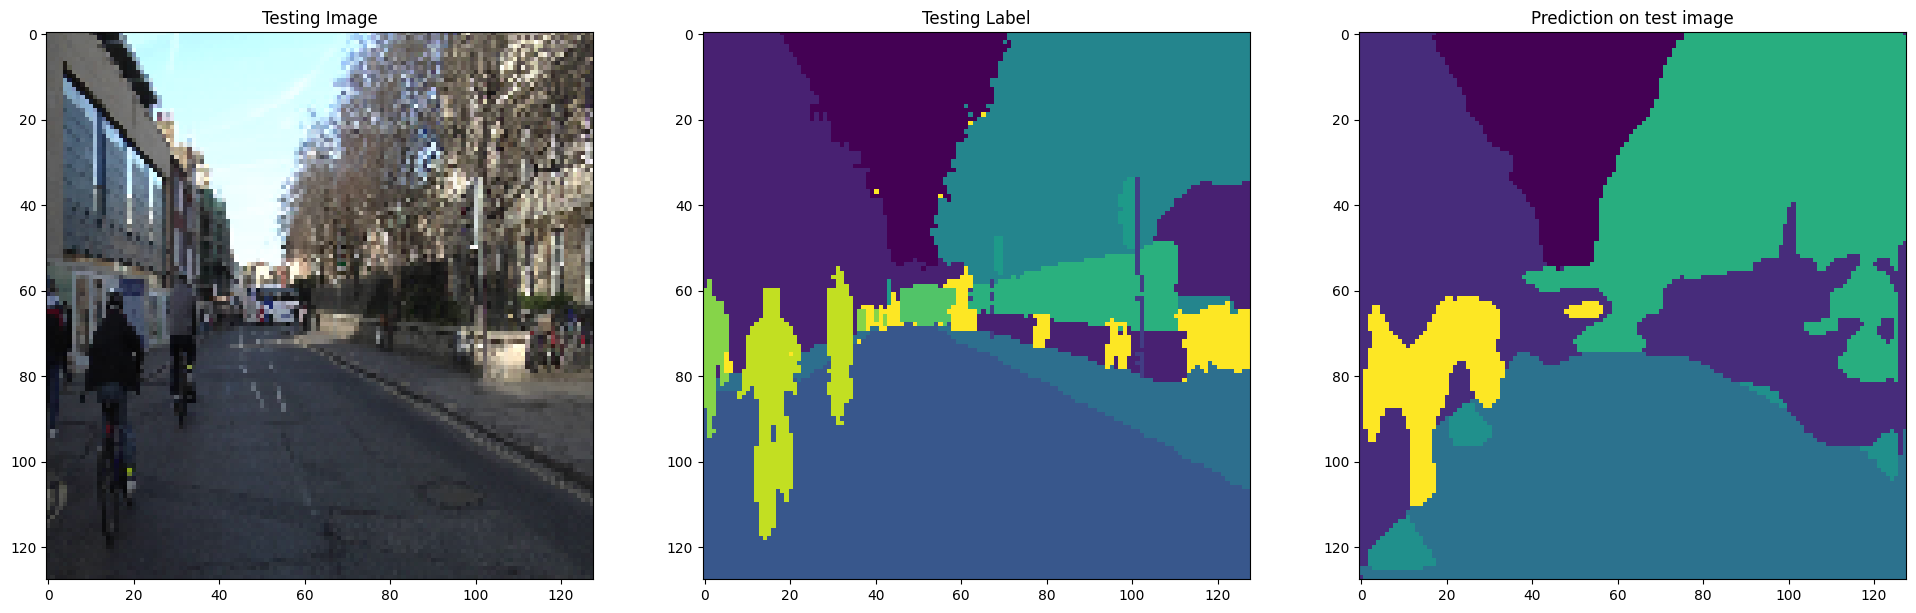

In [27]:
#making predictions
threshold = 0.5
#test_img_number = random.randint(0, num_vals-1)
x, y=validation_datagen.__next__()
for i in range(0,1):
  test_img=x[i]
  ground_truth=y[i]
  print(ground_truth.shape)

# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model_2.predict(test_img_input)[0,:,:,:])
print(prediction.shape)

plt.figure(figsize=(24, 24))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
prediction = np.argmax(prediction, axis=-1)
plt.title('Prediction on test image')
plt.imshow(prediction)

plt.show()